# DSAI HW1 Peak Load Forecasting
  ** Description : 請根據台電歷史資料，預測未來七天的"電力尖峰負載"(MW)
 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.externals import joblib

# Load data

In [4]:
data_read = pd.read_csv("./data.csv")

# plot all training data

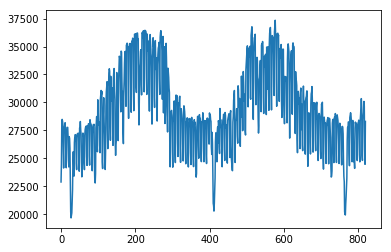

In [5]:
all_train = data_read['尖峰負載(MW)'][0:821]
plt.plot(all_train)
plt.show()

# get the every 60 training data

In [6]:
# use the past 60 days to forecast future 7 days
# generate the data for training
# generate the label data for each 60 training data
for i in range(755):
    temp = data_read['尖峰負載(MW)'][i+0:i+60]
    # data_used = data_read['淨尖峰供電能力(MW)'][0:365]
    templabel = data_read['尖峰負載(MW)'][i+60:i+67]
    x = np.linspace(0, 1, len(temp))
    x = x.reshape(1, -1)

    # print(data_used)
    # print(label)
    temp = np.array(temp)
    templabel = np.array(templabel)
    temp = temp.reshape(1, -1)
    templabel = templabel.reshape(1, -1)

    if(i==0):
        data_used = temp
        label = templabel
    else:
        #print(data_used.shape)
        #print(temp.shape)
        data_used = np.concatenate((data_used, temp), axis=0)
        label = np.concatenate((label, templabel), axis=0)

# Use linear regression model to train

In [7]:
# use linear regression from sklearn to forecast data
# define model
model = LinearRegression()
model.fit(data_used, label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

# Save Model

In [8]:
# save model and load model
# save model
joblib.dump(model, "forecasting_model.m")
# restore model
model = joblib.load("forecasting_model.m")

# Forecasting

In [9]:
# generate the data for testing
test = data_read['尖峰負載(MW)'][761:821]
test = np.array(test)
test = test.reshape(1,-1)

In [10]:
# forecasting
predict = model.predict(test)
predict = np.array(predict)
predict = predict.reshape(7)

print('prediction Result')
print(predict)

prediction Result
[28933.79920613 29118.29167058 29133.15590481 28457.22752498
 26878.55684326 25935.48990853 28651.52680341]


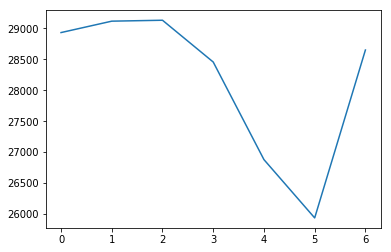

In [11]:
# plot the prediction result
plt.plot(predict)
plt.show()

# 2nd Regression

In [12]:
## 觀察第一次回歸之後的結果，發現回歸趨勢會跟隨著五天上班日與兩天例假日的趨勢
## 對於不定時出現的連假預測結果並不好
## 於是針對不定時出現的連假再 train一個 regression，並使用ensemble的方式串聯兩個 regression model

In [13]:
## prepare for 2nd regression data
train_2nd = []
label_2nd = []
for i in range(755):
    temp = data_read['尖峰負載(MW)'][i+0:i+60]
    tempholiday = data_read['假日'][i+60:i+67]
    templabel_2nd = data_read['尖峰負載(MW)'][i+60:i+67]

    # print(data_used)
    # print(label)
    temp = np.array(temp)
    tempholiday = np.array(tempholiday)
    temp = temp.reshape(1, -1)
    tempholiday = tempholiday.reshape(7)

    templabel_2nd = np.array(templabel_2nd)
    templabel_2nd = templabel_2nd.reshape(7)

    predict_1st = model.predict(temp)
    predict_1st = predict_1st.reshape(7)

    for j in range(7):
        if(tempholiday[j] == -50000):
            train_2nd.append(predict_1st[j])
            label_2nd.append(templabel_2nd[j])

train_2nd = np.array(train_2nd).reshape(-1,1)
label_2nd = np.array(label_2nd).reshape(-1,1)

# 2nd Regression training (only for holidays)

In [14]:
print("start 2nd regression training")
model2 = LinearRegression()
model2.fit(train_2nd, label_2nd)

start 2nd regression training


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

# Save 2nd regression model

In [15]:
# save models
joblib.dump(model2, "forecasting_model2.m")

['forecasting_model2.m']

# Final forecasting (Using ensemble regression models)

In [16]:
test = data_read['尖峰負載(MW)'][761:821]
test = np.array(test)
test = test.reshape(1,-1)
predict = model.predict(test)
predict = np.array(predict)
predict = predict.reshape(7)

test_holiday = data_read['假日'][821:828]
test_holiday = np.array(test_holiday)
test_holiday.reshape(7)

for i in range(7):
    if(test_holiday[i] == -50000 or test_holiday[i] == -25000):
        predict[i] = model2.predict(predict[i].reshape(-1,1))
    predict[i] = np.ceil(predict[i])
    
print('prediction and label')
print(predict.reshape(7))

prediction and label
[28934. 29119. 25517. 25082. 24066. 23459. 28652.]


# Save as .csv

In [17]:
a = [20190402,20190403,20190404,20190405,20190406,20190407,20190408]
dit = {'date':a, 'Peak_Load(MW)':predict.reshape(7)}
df = pd.DataFrame(dit)
df

,date,Peak_Load(MW)
0,20190402,28934.0
1,20190403,29119.0
2,20190404,25517.0
3,20190405,25082.0
4,20190406,24066.0
5,20190407,23459.0
6,20190408,28652.0


In [18]:
df.to_csv(r'./submission.csv',columns=['date','Peak_Load(MW)'],index=False,sep=',')